In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./data/pokedex_enc.csv", index_col=0)

In [3]:
ycols = [c for c in df.columns if "status_" in c]
y = df.loc[:, ycols]
x = df.drop(ycols + ["pokedex_number", "name"], axis=1)
display(y.head())
display(x.head())

,status_Legendary,status_Mythical,status_Normal,status_Sub Legendary
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


,generation,type_number,height_m,weight_kg,abilities_number,total_points,hp,attack,defense,sp_attack,...,species_Wish Pokémon,species_Wolf Pokémon,species_Wood Gecko Pokémon,species_Woodpecker Pokémon,species_Wool Pokémon,species_Woolly Crab Pokémon,species_Worm Pokémon,species_Wrestling Pokémon,species_Young Fowl Pokémon,species_Zen Charm Pokémon
0,1,2,0.7,6.9,2,318.0,45.0,49.0,49.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,1.0,13.0,2,405.0,60.0,62.0,63.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2,2.0,100.0,2,525.0,80.0,82.0,83.0,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,2.4,155.5,1,625.0,80.0,100.0,123.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,0.6,8.5,2,309.0,39.0,52.0,43.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, shuffle=True)

In [5]:
%%time
clf_base = RandomForestClassifier()
clf_base.fit(x_train, y_train)

Wall time: 146 ms


RandomForestClassifier()

In [6]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score

In [7]:
def getAccuracy(y_true, y_pred, names, verbose=True):
    confusion = confusion_matrix(y_true.values.argmax(axis=1), y_pred.argmax(axis=1))
    accuracy = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    f1_w = f1_score(y_true, y_pred, average='weighted')
    f1_u = f1_score(y_true, y_pred, average='macro')
    if verbose:
        print(ycols)
        print(confusion_matrix(y_true.values.argmax(axis=1), y_pred.argmax(axis=1)))
        print(f"accuracy:\t\t{accuracy}\nroc:\t\t\t{roc}\nf1 (weighted):\t\t{f1_w}\nf1 (unweighted):\t{f1_u}")
    return {"accuracy": accuracy, "roc": roc, "f1_w": f1_w, "f1_u": f1_u, "confusion": confusion}

In [8]:
y_pred = clf_base.predict(x_valid)
base_acc = getAccuracy(y_valid, y_pred, ycols)

['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  3   2   0   0]
 [  0   0 137   0]
 [  1   0   0   5]]
accuracy:		0.974025974025974
roc:			0.9041666666666668
f1 (weighted):		0.9825434305953787
f1 (unweighted):	0.8701298701298702


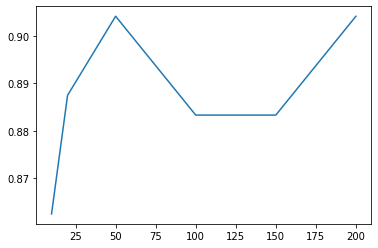

In [9]:
res = []
params = [10, 20, 50, 100, 150, 200]
for n_est in params:
    clf = RandomForestClassifier(n_estimators=n_est)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

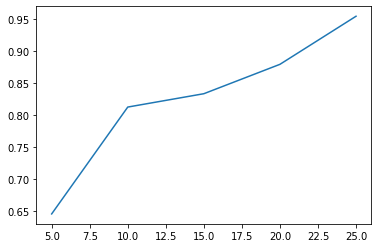

In [10]:
res = []
params = [5, 10, 15, 20, 25, None]
for max_depth in params:
    clf = RandomForestClassifier(max_depth=max_depth)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

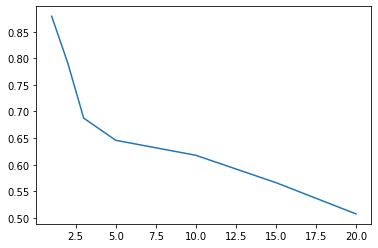

In [11]:
res = []
params = [1, 2, 3, 5, 10, 15, 20]
for min_leaf in params:
    clf = RandomForestClassifier(min_samples_leaf=min_leaf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

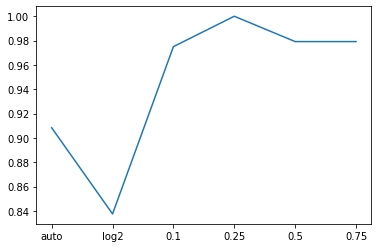

In [12]:
res = []
params = ["auto", "log2", 0.1, 0.25, 0.5, 0.75]
for max_feat in params:
    clf = RandomForestClassifier(max_features=max_feat)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

In [13]:
clf_aug = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=0.5)
clf_aug.fit(x_train, y_train)
y_pred = clf_aug.predict(x_valid)
aug_acc = getAccuracy(y_valid, y_pred, ycols, verbose=False)
print(f"{aug_acc}\n{base_acc}")

{'accuracy': 0.9935064935064936, 'roc': 0.9791666666666667, 'f1_w': 0.9964580873671782, 'f1_u': 0.9772727272727273, 'confusion': array([[  6,   0,   0,   0],
       [  0,   5,   0,   0],
       [  0,   0, 137,   0],
       [  0,   0,   0,   6]], dtype=int64)}
{'accuracy': 0.974025974025974, 'roc': 0.9041666666666668, 'f1_w': 0.9825434305953787, 'f1_u': 0.8701298701298702, 'confusion': array([[  6,   0,   0,   0],
       [  3,   2,   0,   0],
       [  0,   0, 137,   0],
       [  1,   0,   0,   5]], dtype=int64)}


<AxesSubplot:xlabel='feature'>

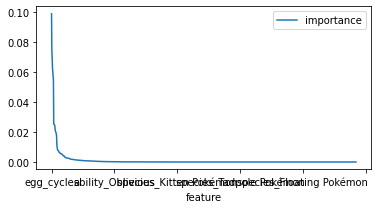

In [14]:
base_importances = pd.DataFrame({"feature": x_train.columns, "importance": clf_base.feature_importances_})
base_importances.sort_values(by=["importance"], ascending=False).plot("feature", "importance", figsize=(6, 3))

In [15]:
print(base_importances.sort_values(by=["importance"], ascending=False).iloc[:50, :])

                         feature  importance
18                    egg_cycles    0.098978
14               base_experience    0.074137
325        egg_type_Undiscovered    0.069824
5                   total_points    0.062838
12                    catch_rate    0.059552
13               base_friendship    0.057362
17               percentage_male    0.054919
2                       height_m    0.025394
9                      sp_attack    0.025081
3                      weight_kg    0.024956
6                             hp    0.024578
15                   growth_rate    0.022301
7                         attack    0.020731
11                         speed    0.020305
4               abilities_number    0.019687
10                    sp_defense    0.018824
8                        defense    0.017401
70           ability_Beast Boost    0.011150
0                     generation    0.009706
20                  against_fire    0.008241
27                against_ground    0.007816
24        

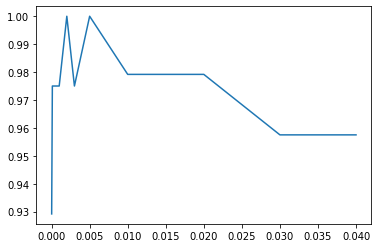

In [16]:
res = []
params = [1e-5, 1e-4, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04]
for cutoff in params:
    trimmed_x_train = x_train.drop(base_importances[base_importances["importance"] < cutoff]["feature"], axis=1)
    trimmed_x_valid = x_valid.drop(base_importances[base_importances["importance"] < cutoff]["feature"], axis=1)
    clf = RandomForestClassifier(n_estimators=150, max_depth=15)
    clf.fit(trimmed_x_train, y_train)
    y_pred = clf.predict(trimmed_x_valid)
    res.append(getAccuracy(y_valid, y_pred, ycols, verbose=False))
    
plt.plot(params, [x["roc"] for x in res])

In [17]:
trimmed_x_train = x_train.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)
trimmed_x_valid = x_valid.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)
clf_trimmed = RandomForestClassifier(n_estimators=150, max_depth=15)
clf_trimmed.fit(trimmed_x_train, y_train)
y_pred = clf_trimmed.predict(trimmed_x_valid)
trimmed_acc = getAccuracy(y_valid, y_pred, ycols, verbose=False)
print(f"{trimmed_acc}\n{aug_acc}\n{base_acc}")

{'accuracy': 0.9935064935064936, 'roc': 0.9791666666666667, 'f1_w': 0.9964580873671782, 'f1_u': 0.9772727272727273, 'confusion': array([[  6,   0,   0,   0],
       [  0,   5,   0,   0],
       [  0,   0, 137,   0],
       [  0,   0,   0,   6]], dtype=int64)}
{'accuracy': 0.9935064935064936, 'roc': 0.9791666666666667, 'f1_w': 0.9964580873671782, 'f1_u': 0.9772727272727273, 'confusion': array([[  6,   0,   0,   0],
       [  0,   5,   0,   0],
       [  0,   0, 137,   0],
       [  0,   0,   0,   6]], dtype=int64)}
{'accuracy': 0.974025974025974, 'roc': 0.9041666666666668, 'f1_w': 0.9825434305953787, 'f1_u': 0.8701298701298702, 'confusion': array([[  6,   0,   0,   0],
       [  3,   2,   0,   0],
       [  0,   0, 137,   0],
       [  1,   0,   0,   5]], dtype=int64)}


In [18]:
getAccuracy(y_test, clf_base.predict(x_test), ycols, verbose=True)
getAccuracy(y_test, clf_aug.predict(x_test), ycols, verbose=True)
getAccuracy(y_test, 
            clf_trimmed.predict(x_test.drop(base_importances[base_importances["importance"] < 0.02]["feature"], axis=1)), 
            ycols, verbose=True)

['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  2   2   0   0]
 [  0   0 138   0]
 [  3   0   0   4]]
accuracy:		0.9612903225806452
roc:			0.8630952380952381
f1 (weighted):		0.9755620723362659
f1 (unweighted):	0.8257575757575757
['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  0   4   0   0]
 [  0   0 138   0]
 [  1   0   0   6]]
accuracy:		0.9935483870967742
roc:			0.9821428571428572
f1 (weighted):		0.9965260545905706
f1 (unweighted):	0.9807692307692307
['status_Legendary', 'status_Mythical', 'status_Normal', 'status_Sub Legendary']
[[  6   0   0   0]
 [  0   4   0   0]
 [  0   0 138   0]
 [  1   0   0   6]]
accuracy:		0.9935483870967742
roc:			0.9821428571428572
f1 (weighted):		0.9965260545905706
f1 (unweighted):	0.9807692307692307


{'accuracy': 0.9935483870967742,
 'roc': 0.9821428571428572,
 'f1_w': 0.9965260545905706,
 'f1_u': 0.9807692307692307,
 'confusion': array([[  6,   0,   0,   0],
        [  0,   4,   0,   0],
        [  0,   0, 138,   0],
        [  1,   0,   0,   6]], dtype=int64)}